In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
import matplotlib.patches as mpatches
from skimage import exposure

In [2]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy version: 1.26.2
Matplotlib version: 3.8.2
SITK version: 2.3.1
Scikit-image version: 0.22.0


In [3]:
patient_id = 20

In [4]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)

### load the MHA

In [5]:
image_01 = sitk.GetArrayFromImage(sitk.ReadImage('{}/phase-01.mha'.format(PREPROCESSED_MHA_DIR)))
image_02 = sitk.GetArrayFromImage(sitk.ReadImage('{}/phase-02.mha'.format(PREPROCESSED_MHA_DIR)))
mask = sitk.GetArrayFromImage(sitk.ReadImage('{}/mask.mha'.format(PREPROCESSED_MHA_DIR))).astype(bool)

jacobian_det = sitk.GetArrayFromImage(sitk.ReadImage('{}/vf_jac.mha'.format(PREPROCESSED_MHA_DIR)))
ventilation = jacobian_det-1.0
ventilation[~mask] = np.min(ventilation)

/home/daryl/miniconda3/envs/py310/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
print(image_01.shape, image_02.shape, mask.shape, jacobian_det.shape, ventilation.shape)

(250, 304, 304) (250, 304, 304) (250, 304, 304) (250, 304, 304) (250, 304, 304)


In [7]:
prop = np.sum(np.array(jacobian_det[mask]) < 0) / len(jacobian_det[mask].ravel())
print('proportion of voxels with negative values in Jacobian determinant = {}'.format(round(prop, 2)))

proportion of voxels with negative values in Jacobian determinant = 0.31


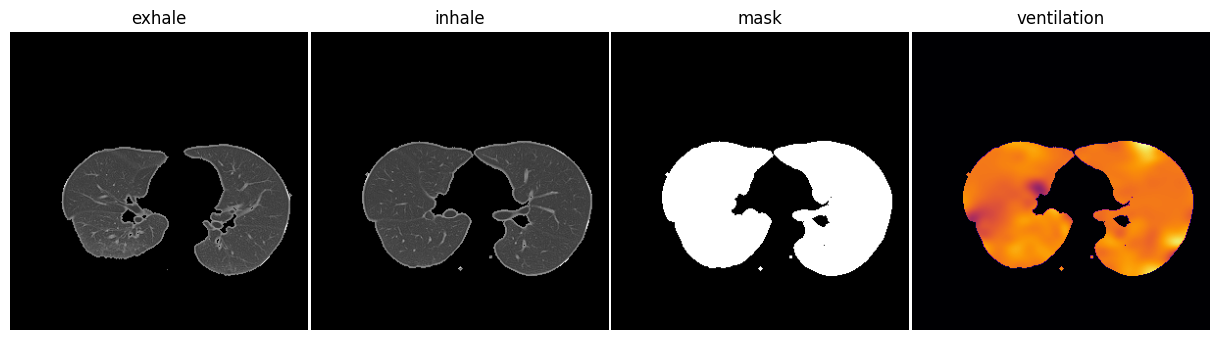

In [8]:
DISPLAY_IDX = 100

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))
ax1.imshow(image_01[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale')
ax1.set_axis_off()

ax2.imshow(image_02[DISPLAY_IDX], cmap="gray")
ax2.set_title('inhale')
ax2.set_axis_off()

ax3.imshow(mask[DISPLAY_IDX], cmap="gray")
ax3.set_title('mask')
ax3.set_axis_off()

ax4.imshow(ventilation[DISPLAY_IDX], cmap="inferno")
ax4.set_title('ventilation')
ax4.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

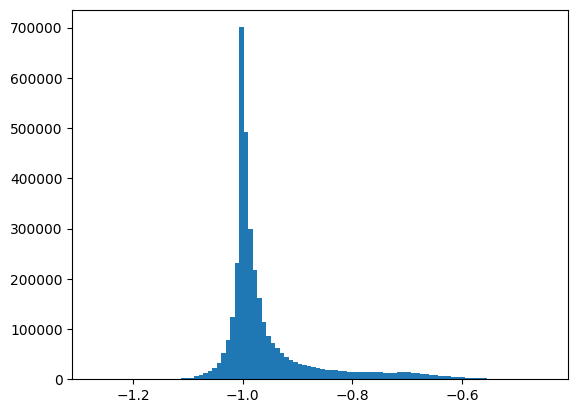

In [9]:
arr = ventilation[mask].ravel()
_ = plt.hist(arr, bins=100)

In [10]:
percentile_high = np.percentile(arr,70)
percentile_medium = np.percentile(arr,30)

In [11]:
percentile_high,percentile_medium

(-0.9656108021736145, -1.0003615617752075)

In [12]:
high_func_idxs = (ventilation>percentile_high)
med_func_idxs = (ventilation<=percentile_high) & (ventilation>=percentile_medium)
low_func_idxs = (ventilation<percentile_medium) & (ventilation>np.min(ventilation))

ventilation_label_arr = np.full_like(ventilation, 0)
ventilation_label_arr[high_func_idxs] = 1
ventilation_label_arr[med_func_idxs] = 2
ventilation_label_arr[low_func_idxs] = 3

#### compare Plastimatch-generated ventilation against PET ground truth

In [13]:
# load PET ground truth
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/training-set'

output_name = '{}/Patient{:02d}.npy'.format(PREPROCESSED_BASE_DIR, patient_id)
pt_arr = np.load(output_name)
print('loaded stack from {}'.format(output_name))

pet_arr = pt_arr[2]
pet_label_arr = pt_arr[3]

loaded stack from /mnt/data/datasets/RNSH_HFlung/training-set/Patient20.npy


In [14]:
np.min(ventilation), np.max(ventilation)

(-1.2798693, -0.4473266)

In [15]:
np.min(pet_arr), np.max(pet_arr)

(-4.6984245e-05, 1.0)

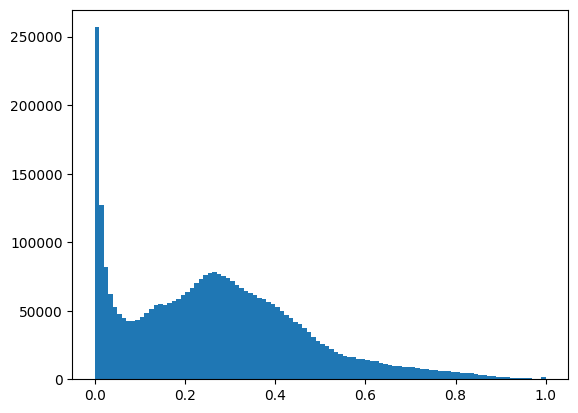

In [16]:
arr = pet_arr[mask].ravel()
_ = plt.hist(arr, bins=100)

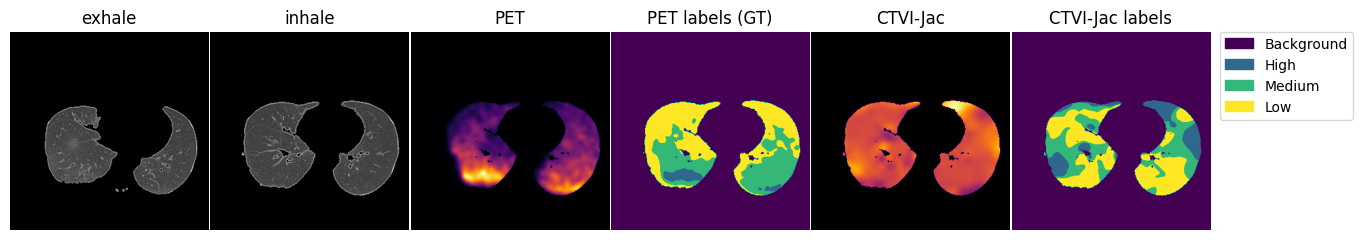

In [17]:
DISPLAY_IDX = 150

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15,4))
ax1.imshow(image_01[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale')
ax1.set_axis_off()

ax2.imshow(image_02[DISPLAY_IDX], cmap="gray")
ax2.set_title('inhale')
ax2.set_axis_off()

ax3.imshow(pet_arr[DISPLAY_IDX], cmap="inferno")
ax3.set_title('PET')
ax3.set_axis_off()

im = ax4.imshow(pet_label_arr[DISPLAY_IDX])
ax4.set_title('PET labels (GT)')
ax4.set_axis_off()

ax5.imshow(ventilation[DISPLAY_IDX], cmap="inferno")
ax5.set_title('CTVI-Jac')
ax5.set_axis_off()

ax6.imshow(ventilation_label_arr[DISPLAY_IDX])
ax6.set_title('CTVI-Jac labels')
ax6.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

# get the colors of the values, according to the 
# colormap used by imshow
values = np.unique(ventilation_label_arr.ravel())
label_names = {0:'Background', 1:'High', 2:'Medium', 3:'Low'}
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=label_names[i] ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

#### compare raw ventilation similarity

In [18]:
normalised_pet_arr = exposure.rescale_intensity(pet_arr, in_range='image', out_range=(1e-3,1.))
normalised_ventilation = exposure.rescale_intensity(ventilation, in_range='image', out_range=(1e-3,1.))

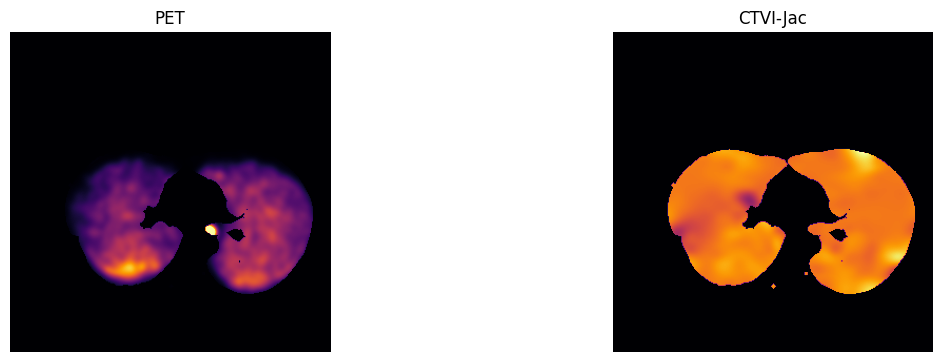

In [19]:
DISPLAY_IDX = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.imshow(normalised_pet_arr[DISPLAY_IDX], cmap="inferno")
ax1.set_title('PET')
ax1.set_axis_off()

ax2.imshow(normalised_ventilation[DISPLAY_IDX], cmap="inferno")
ax2.set_title('CTVI-Jac')
ax2.set_axis_off()

# fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=1.0, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

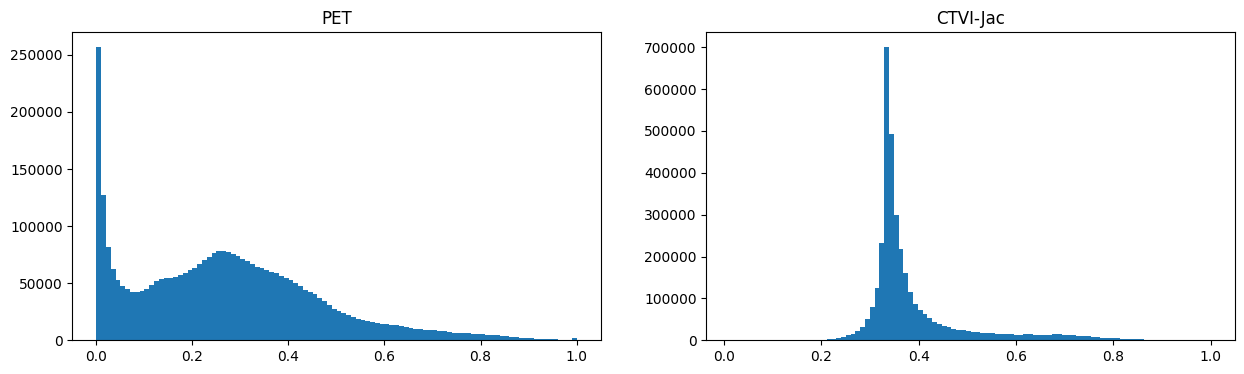

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

# arr = normalised_pet_arr[normalised_pet_arr>0.05].ravel()
arr = normalised_pet_arr[mask].ravel()
_ = ax1.hist(arr, bins=100)
_ = ax1.set_title('PET')

arr = normalised_ventilation[mask].ravel()
_ = ax2.hist(arr, bins=100)
_ = ax2.set_title('CTVI-Jac')

In [21]:
sp = spearmanr(normalised_ventilation[mask].ravel(), normalised_pet_arr[mask].ravel())
print('Spearman: {}'.format(np.round(sp[0],2)))

Spearman: 0.08


#### compare segmentation similarity

In [22]:
seg = ventilation_label_arr.ravel()
gt = pet_label_arr.ravel()

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
cm = confusion_matrix(gt, seg)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

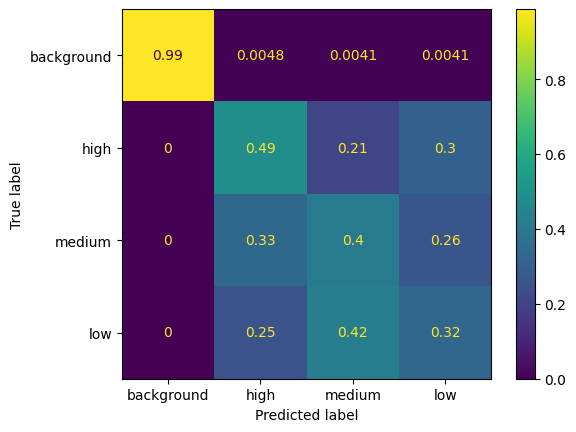

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()

In [26]:
dsc = {}
print('DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(seg[gt==k]==k)*2.0 / (np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))
    dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

DSC
high: 0.1
medium: 0.39
low: 0.41


In [27]:
labels = [0, 1, 2, 3]

metrics = sg.write_metrics(labels=labels,
                  gdth_img=ventilation_label_arr,
                  pred_img=pet_label_arr,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

In [28]:
vs = metrics[0]['vs']
print('volume similarity')
print('high: {}'.format(round(vs[1],2)))
print('medium: {}'.format(round(vs[2],2)))
print('low: {}'.format(round(vs[3],2)))

volume similarity
high: 1.61
medium: 0.05
low: -0.53


In [29]:
hd = metrics[0]['hd']
print('Hausdorff distance')
print('high: {}'.format(round(hd[1])))
print('medium: {}'.format(round(hd[2])))
print('low: {}'.format(round(hd[3])))

Hausdorff distance
high: 105
medium: 70
low: 96


In [30]:
hd95 = metrics[0]['hd95']
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(hd95[1])))
print('medium: {}'.format(round(hd95[2])))
print('low: {}'.format(round(hd95[3])))

Hausdorff distance 95% percentile
high: 89
medium: 29
low: 30


#### store the metrics by dataset and test patient ID

In [31]:
ANALYSIS_DIR = '/home/daryl/analysis'
ANALYSIS_FILE = '{}/dir-metrics.pkl'.format(ANALYSIS_DIR)

In [32]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)

patient_d = {'patient_id':patient_id,
             'confusion_matrix':cm, 'spearman_correlation':np.round(sp[0],2), 
             'DSC_low':np.round(dsc['low'],2), 'DSC_medium':np.round(dsc['medium'],2), 'DSC_high':np.round(dsc['high'],2),
             'VS_low':np.round(vs[3],2), 'VS_medium':np.round(vs[2],2), 'VS_high':np.round(vs[1],2),
             'HD_low':np.round(hd[3]), 'HD_medium':np.round(hd[2]), 'HD_high':np.round(hd[1]),
             'HD95_low':np.round(hd95[3]), 'HD95_medium':np.round(hd95[2]), 'HD95_high':np.round(hd95[1]),
            }

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

patient_id_str = '{:03d}'.format(patient_id)
analysis_d[patient_id_str] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
        pickle.dump(analysis_d, f)

In [33]:
len(analysis_d)

20